**Objective:-**
 

*   Find the best model to classify the image dataset according to their types of sleeves .

**Note :- **
* We have divided our image dataset into train( 1482 images ) and test( 520 images ).

* We have resized all the images to (224 , 224) as it has no major effect on our model .

* We have augumented all the images during training inorder to improve our results .

* We will go over the following options:

      1) using the bottleneck features of a pre-trained VGG16 network
    
      2) fine-tuning the top layers of a pre-trained network .


In [0]:
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras import applications
from keras.models import Model
import math
import matplotlib.pyplot as plt
from keras.utils import np_utils
from prettytable import PrettyTable
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


Setting the directories of our dataset

In [0]:
img_width, img_height = 224 , 224
train_data_dir = 'train'
validation_data_dir = 'validation'

In [0]:
def fcount(path):    
    listOfclasses = [name for name in os.listdir(path)] 
    return len(listOfclasses),listOfclasses

In [0]:
def gcd(a, b):
    if(a<b):
        a,b=b,a
    while(b!=0):
        r=b
        b=a%r
        a=r
    return a

In [0]:
train_labels,nameOfClasses = fcount("train/")
validation_labels,nameOfClasses= fcount("validation/")
nameOfClasses.sort()


Getting number of training and validation lables .

In [12]:
train_labels,validation_labels

(13, 13)

In [13]:
print(nameOfClasses)

['34_sleeve', 'angel_sleeve', 'bell_sleeve', 'bishop_sleeve', 'butterfly_sleeve', 'cap_sleeve', 'cape_sleeve', 'cold-shoulder', 'kimono_sleeve', 'long_sleeve', 'puff_sleeve', 'short_sleeve', 'sleeveless']


Preparing the dataset for pre-processing .
Data Augumentation is also being done on train data .

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size = gcd(train_labels*114,validation_labels*40)

In [15]:
train_generator_bottleneck = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

validation_generator_bottleneck = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 1482 images belonging to 13 classes.
Found 520 images belonging to 13 classes.


Setting the number of Epochs to run and finding the number of Training and Validation samples

In [0]:
epochs = 25
train_samples = train_labels*114
validation_samples = validation_labels*40


# **Using the bottleneck features of a pre-trained VGG16 network**

In [17]:
model_vgg = applications.VGG16(include_top=False, weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


We will save the weights of both training and validation weights and then load back to increase the time efficiency

In [0]:
bottleneck_features_train = model_vgg.predict_generator(train_generator_bottleneck, train_samples // batch_size)
np.save('bottleneck_features_train.npy', bottleneck_features_train)

In [0]:
bottleneck_features_validation = model_vgg.predict_generator(validation_generator_bottleneck, validation_samples // batch_size)
np.save('bottleneck_features_validation.npy', bottleneck_features_validation)


Creating lables for our training and validation samples

In [0]:
train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
b = []
for x in range(len(nameOfClasses)):
    for y in range(1,115):
        b.append(x)
train_labels = np.asarray(b)


validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
c = []
for x in range(len(nameOfClasses)):
    for y in range(1,41):
        c.append(x)
validation_labels = np.asarray(c)

In [21]:
train_labels

array([ 0,  0,  0, ..., 12, 12, 12])

Convert 1-dimensional class arrays to n-dimensional class matrices (one hot vector encoding)

In [0]:
train_labels = np_utils.to_categorical(train_labels,len(nameOfClasses))
validation_labels = np_utils.to_categorical(validation_labels, len(nameOfClasses))

In [23]:
train_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

**Creating the model and running it**

In [24]:
model_top = Sequential()
model_top.add(Flatten(input_shape=train_data.shape[1:]))
model_top.add(Dropout(0.5))
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(len(nameOfClasses), activation='softmax'))

model_top.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [25]:
history=model_top.fit(train_data, train_labels,
            epochs=epochs, 
            batch_size=batch_size,
            validation_data=(validation_data, validation_labels))

Instructions for updating:
Use tf.cast instead.
Train on 1482 samples, validate on 520 samples
Epoch 1/25
1482/1482 [==============================] - 1s 844us/step - loss: 0.5621 - acc: 0.9039 - val_loss: 0.2723 - val_acc: 0.9231
Epoch 2/25
1482/1482 [==============================] - 1s 480us/step - loss: 0.2742 - acc: 0.9231 - val_loss: 0.2700 - val_acc: 0.9231
Epoch 3/25
1482/1482 [==============================] - 1s 470us/step - loss: 0.2688 - acc: 0.9231 - val_loss: 0.2688 - val_acc: 0.9231
Epoch 4/25
1482/1482 [==============================] - 1s 538us/step - loss: 0.2654 - acc: 0.9232 - val_loss: 0.2664 - val_acc: 0.9231
Epoch 5/25
1482/1482 [==============================] - 1s 528us/step - loss: 0.2605 - acc: 0.9241 - val_loss: 0.2636 - val_acc: 0.9231
Epoch 6/25
1482/1482 [==============================] - 1s 552us/step - loss: 0.2577 - acc: 0.9239 - val_loss: 0.2608 - val_acc: 0.9231
Epoch 7/25
1482/1482 [==============================] - 1s 496us/step - loss: 0.2513 - ac

**Plot **

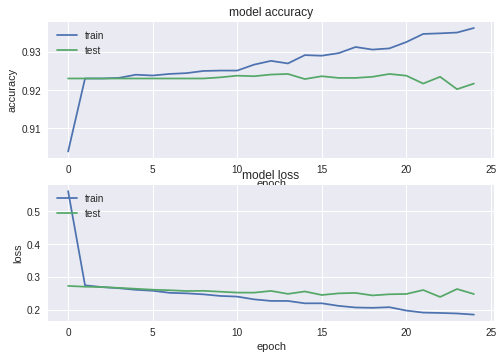

In [26]:
plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Saving the trained weights .

In [0]:
model_top.save_weights('Test_bottleneck_50_epochs.h5')

**Obsevations :-**

*   Train Accuracy :- 0.9363 , Train Loss :- 0.1847
*   Test Accuracy :- 0.9217 , Test Loss :- 0.2475



# Fine-tuning the top layers of a a pre-trained network

In [0]:
model_2 = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [29]:
model_2.output_shape[1:]

(7, 7, 512)

In [0]:
top_model = Sequential()
top_model.add(Flatten(input_shape=model_2.output_shape[1:]))
top_model.add(Dropout(0.5))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(len(nameOfClasses), activation='softmax'))
top_model.load_weights('Test_bottleneck_50_epochs.h5')


In [0]:
model = Model(inputs = model_2.input, outputs = top_model(model_2.output))

Freeze all convolutional layers up to the last convolutional block

In [0]:
for layer in model.layers[:15]:
    layer.trainable = False

compile the model with a SGD/momentum optimizer and a very slow learning rate.

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])


Finally, we start training the whole new model with augumented train images .

In [34]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size
        )

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size
        )

Found 1482 images belonging to 13 classes.
Found 520 images belonging to 13 classes.


Fine-tune the model

In [35]:
history=model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size)

Epoch 1/25
57/57 [==============================] - 41s 718ms/step - loss: 0.2217 - acc: 0.9284 - val_loss: 0.2443 - val_acc: 0.9228
Epoch 2/25
57/57 [==============================] - 36s 638ms/step - loss: 0.2189 - acc: 0.9294 - val_loss: 0.2422 - val_acc: 0.9234
Epoch 3/25
57/57 [==============================] - 37s 642ms/step - loss: 0.2188 - acc: 0.9297 - val_loss: 0.2417 - val_acc: 0.9231
Epoch 4/25
57/57 [==============================] - 36s 634ms/step - loss: 0.2142 - acc: 0.9304 - val_loss: 0.2403 - val_acc: 0.9237
Epoch 5/25
57/57 [==============================] - 36s 636ms/step - loss: 0.2204 - acc: 0.9296 - val_loss: 0.2411 - val_acc: 0.9234
Epoch 6/25
57/57 [==============================] - 36s 636ms/step - loss: 0.2145 - acc: 0.9310 - val_loss: 0.2400 - val_acc: 0.9241
Epoch 7/25
57/57 [==============================] - 36s 639ms/step - loss: 0.2174 - acc: 0.9306 - val_loss: 0.2404 - val_acc: 0.9238
Epoch 8/25
57/57 [==============================] - 36s 638ms/step - 

**Plot**

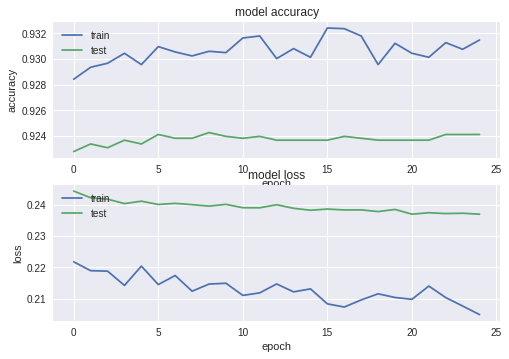

In [36]:
plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

**Obsevations :-**

*   Train Accuracy :- 0.9315 , Train Loss :- 0.2049
*   Test Accuracy :- 0.9241 , Test Loss :- 0.2369
*   Model accuracy improved by approx 0.2% .




In [0]:
model.save_weights('FinalStaticModel_25epochs_vgg.h5')

**Predicting the output**

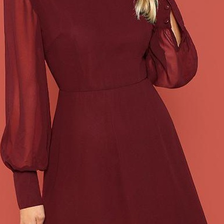

In [55]:
img

In [65]:
img = load_img("validation/rahul.jpg", (224,224))
x = img_to_array(img)
predictions = model.predict(x.reshape((1,) + x.shape))
result = dict()
i = 0
for x in predictions.tolist()[0]:
        result[nameOfClasses[i]] = round(x,13)
        i+=1
print(result)

{'34_sleeve': 0.0, 'angel_sleeve': 0.0, 'bell_sleeve': 0.0, 'bishop_sleeve': 0.0098977284506, 'butterfly_sleeve': 0.0, 'cap_sleeve': 0.0, 'cape_sleeve': 0.0, 'cold-shoulder': 0.0, 'kimono_sleeve': 0.0, 'long_sleeve': 0.4173830747604, 'puff_sleeve': 0.5727191567421, 'short_sleeve': 0.0, 'sleeveless': 0.0}


**Final Table**

In [68]:
x = PrettyTable()
x.field_names = ["Approach", "Train Accuracy", "Train Loss", "Test Accuracy","Test Loss"]
x.add_row(["Using the bottleneck features of a pre-trained VGG16 network",0.9363,0.1847,0.9217,0.2475])
x.add_row(["Fine-tuning the top layers of a a pre-trained network",0.9315,0.2049,0.9241,0.2369])
print(x)

+--------------------------------------------------------------+----------------+------------+---------------+-----------+
|                           Approach                           | Train Accuracy | Train Loss | Test Accuracy | Test Loss |
+--------------------------------------------------------------+----------------+------------+---------------+-----------+
| Using the bottleneck features of a pre-trained VGG16 network |     0.9363     |   0.1847   |     0.9217    |   0.2475  |
|    Fine-tuning the top layers of a a pre-trained network     |     0.9315     |   0.2049   |     0.9241    |   0.2369  |
+--------------------------------------------------------------+----------------+------------+---------------+-----------+


**APPROACH**

**1. Using the bottleneck features of a pre-trained VGG16 network **

We will use the VGG16 architecture, pre-trained on the ImageNet dataset --a model previously featured on this blog. Because the ImageNet dataset contains several "cat" classes (persian cat, siamese cat...) and many "dog" classes among its total of 1000 classes, this model will already have learned features that are relevant to our classification problem. In fact, it is possible that merely recording the softmax predictions of the model over our data rather than the bottleneck features would be enough to solve our dogs vs. cats classification problem extremely well. However, the method we present here is more likely to generalize well to a broader range of problems, including problems featuring classes absent from ImageNet. 

Our strategy will be as follow: we will only instantiate the convolutional part of the model, everything up to the fully-connected layers. We will then run this model on our training and validation data once, recording the output (the "bottleneck features" from th VGG16 model: the last activation maps before the fully-connected layers) in two numpy arrays. Then we will train a small fully-connected model on top of the stored features. 

The reason why we are storing the features offline rather than adding our fully-connected model directly on top of a frozen convolutional base and running the whole thing, is computational effiency. Running VGG16 is expensive, especially if you're working on CPU, and we want to only do it once. Note that this prevents us from using data augmentation but we have augumented the data .

**2. Fine-tuning the top layers of a a pre-trained network**

To further improve our previous result, we can try to "fine-tune" the last convolutional block of the VGG16 model alongside the top-level classifier. Fine-tuning consist in starting from a trained network, then re-training it on a new dataset using very small weight updates. In our case, this can be done in 3 steps:

1) instantiate the convolutional base of VGG16 and load its weights 

2) add our previously defined fully-connected model on top, and load its weights 

3) freeze the layers of the VGG16 model up to the last convolutional block

Note that:

We choose to only fine-tune the last convolutional block rather than the entire network in order to prevent overfitting, since the entire network would have a very large entropic capacity and thus a strong tendency to overfit. The features learned by low-level convolutional blocks are more general, less abstract than those found higher-up, so it is sensible to keep the first few blocks fixed (more general features) and only fine-tune the last one (more specialized features). Fine-tuning should be done with a very slow learning rate, and typically with the SGD optimizer rather than an adaptative learning rate optimizer such as RMSProp. This is to make sure that the magnitude of the updates stays very small